<a href="https://colab.research.google.com/github/JoseAlbertoSeco/BlablacarCarpooling_DataMining/blob/Patterns/notebooks/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linea de trabajo 2:

En este notebook se realizará un algoritmo de regresión, con esto se pretende que la empresa tome decisiones. Responderemos a la pregunta: 

¿Si de momento tengo los datos sobre determinados viajes a una ciudad como pueden ser, la fecha, el orige, destino, el número de persona que ha ofertado, o los asientos que ya están completos, cuantos viajes de todos los disponibles se realizarán al final?

Con esto se pretende ayudar a la empresa a la hora de tomar decisiones como podrían ser decisiones publicitarias sobre viajes, poner anuncios sobre un determinado viaje, etc.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn import linear_model
from sklearn import tree 

from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

# Carga de datos

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!wget https://github.com/JoseAlbertoSeco/BlablacarCarpooling_DataMining/raw/main/data/processed/ccaa.csv

--2022-01-24 00:36:47--  https://github.com/JoseAlbertoSeco/BlablacarCarpooling_DataMining/raw/main/data/processed/ccaa.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JoseAlbertoSeco/BlablacarCarpooling_DataMining/main/data/processed/ccaa.csv [following]
--2022-01-24 00:36:47--  https://raw.githubusercontent.com/JoseAlbertoSeco/BlablacarCarpooling_DataMining/main/data/processed/ccaa.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299179 (292K) [text/plain]
Saving to: ‘ccaa.csv.1’

ccaa.csv.1          100%[===================>] 292.17K  --.-KB/s    in 0.04s   

2022-01-24 00:36:47 (7.97 

## Carga provincial

In [4]:
andalucia = pd.read_csv("/content/drive/MyDrive/Datos/df_andalucia.csv") 
andalucia = andalucia.drop(andalucia.columns[[0]], axis=1)
andalucia.head(3)

,DIA,AÑO,SEMANA,MES,PAIS,ORIGEN,DESTINO,ASIENTOS_OFERTADOS,ASIENTOS_CONFIRMADOS,VIAJES_OFERTADOS,VIAJES_CONFIRMADOS,OFERTANTES,OFERTANTES_NUEVOS,CA_ORIGEN,CA_DESTINO,PROVINCIA_ORIGEN,PROVINCIA_DESTINO,INTERPROVINCIAL,Festivo
0,2017-11-01,2017,44,11,es,Albox,Granada,1.0,1,1,1,1,0,Andalucía,Andalucía,Almería,Granada,No,Si
1,2017-11-03,2017,44,11,es,Albox,Granada,12.0,1,4,1,4,0,Andalucía,Andalucía,Almería,Granada,No,No
2,2017-11-05,2017,44,11,es,Albox,Granada,2.0,1,1,1,1,0,Andalucía,Andalucía,Almería,Granada,No,No


In [5]:
clm = pd.read_csv("/content/drive/MyDrive/Datos/df_castilla.csv") 
clm = clm.drop(clm.columns[[0]], axis=1)
clm.head(3)

,DIA,AÑO,SEMANA,MES,PAIS,ORIGEN,DESTINO,ASIENTOS_OFERTADOS,ASIENTOS_CONFIRMADOS,VIAJES_OFERTADOS,VIAJES_CONFIRMADOS,OFERTANTES,OFERTANTES_NUEVOS,CA_ORIGEN,CA_DESTINO,PROVINCIA_ORIGEN,PROVINCIA_DESTINO,INTERPROVINCIAL,Festivo
0,2017-11-05,2017,44,11,es,Albacete,Guadalajara,11.0,1,6,1,6,1,Castilla-La Mancha,Castilla-La Mancha,Albacete,Guadalajara,No,No
1,2017-11-12,2017,45,11,es,Albacete,Guadalajara,11.0,1,6,1,6,1,Castilla-La Mancha,Castilla-La Mancha,Albacete,Guadalajara,No,No
2,2017-11-19,2017,46,11,es,Albacete,Guadalajara,8.0,1,6,1,6,0,Castilla-La Mancha,Castilla-La Mancha,Albacete,Guadalajara,No,No


In [6]:
ccaa = pd.read_csv("ccaa.csv") 
ccaa.head(3)

,Municipio,Autonomía,Provincia
0,Alegría-Dulantzi,País Vasco,Araba/Álava
1,Amurrio,País Vasco,Araba/Álava
2,Aramaio,País Vasco,Araba/Álava


# Label Encoding

En esta sección transformamos las variables categóricas que utilizaremos para crear el modelo en variables numéricas. 

Se utilizará LabelEncoding, el cual codifica cada sucesión de letras (palabra) en un número, actua a forma de diccionario.

Por ejemplo: {'Sevilla':1, 'Lepe':2}

También eliminaremos algunas variables que no nos resultan de utilidad a la hora de crear el modelo.

## Encoding Andalucia

In [7]:
andalucia_encoded = andalucia.copy()

In [8]:
andalucia_encoded['ORIGEN_E'] = andalucia['ORIGEN'].astype('category').cat.codes
andalucia_encoded['DESTINO_E'] = andalucia['DESTINO'].astype('category').cat.codes
andalucia_encoded['INTERPROVINCIAL_E'] = andalucia['INTERPROVINCIAL'].astype('category').cat.codes
andalucia_encoded['FESTIVO'] = andalucia_encoded['Festivo'].astype('category').cat.codes

In [9]:
andalucia_encoded.tail(2)

,DIA,AÑO,SEMANA,MES,PAIS,ORIGEN,DESTINO,ASIENTOS_OFERTADOS,ASIENTOS_CONFIRMADOS,VIAJES_OFERTADOS,VIAJES_CONFIRMADOS,OFERTANTES,OFERTANTES_NUEVOS,CA_ORIGEN,CA_DESTINO,PROVINCIA_ORIGEN,PROVINCIA_DESTINO,INTERPROVINCIAL,Festivo,ORIGEN_E,DESTINO_E,INTERPROVINCIAL_E,FESTIVO
246053,2018-06-08,2018,23,6,es,Mairena del Aljarafe,Corteconcepción,3.0,2,1,1,1,1,Andalucía,Andalucía,Sevilla,Huelva,No,No,296,142,0,0
246054,2018-07-06,2018,27,7,es,Tomares,Algámitas,4.0,1,1,1,1,0,Andalucía,Andalucía,Sevilla,Sevilla,Si,No,428,25,1,0


In [10]:
andalucia_encoded = andalucia_encoded.drop(labels=['ORIGEN','Festivo','PAIS','DESTINO', 'CA_ORIGEN', 'CA_DESTINO', 'PROVINCIA_ORIGEN', 'PROVINCIA_DESTINO', 'INTERPROVINCIAL'], axis=1)


In [11]:
andalucia_encoded.head(3)

,DIA,AÑO,SEMANA,MES,ASIENTOS_OFERTADOS,ASIENTOS_CONFIRMADOS,VIAJES_OFERTADOS,VIAJES_CONFIRMADOS,OFERTANTES,OFERTANTES_NUEVOS,ORIGEN_E,DESTINO_E,INTERPROVINCIAL_E,FESTIVO
0,2017-11-01,2017,44,11,1.0,1,1,1,1,0,6,218,0,1
1,2017-11-03,2017,44,11,12.0,1,4,1,4,0,6,218,0,0
2,2017-11-05,2017,44,11,2.0,1,1,1,1,0,6,218,0,0


In [12]:
andalucia_encoded = andalucia_encoded.rename(columns={'ORIGEN_E':'ORIGEN','DESTINO_E':'DESTINO','INTERPROVINCIAL_E': 'INTERPROVINCIAL'})

In [13]:
andalucia_encoded.head(2)

,DIA,AÑO,SEMANA,MES,ASIENTOS_OFERTADOS,ASIENTOS_CONFIRMADOS,VIAJES_OFERTADOS,VIAJES_CONFIRMADOS,OFERTANTES,OFERTANTES_NUEVOS,ORIGEN,DESTINO,INTERPROVINCIAL,FESTIVO
0,2017-11-01,2017,44,11,1.0,1,1,1,1,0,6,218,0,1
1,2017-11-03,2017,44,11,12.0,1,4,1,4,0,6,218,0,0


## Encoding Castilla-La Mancha

In [14]:
clm_encoded = clm.copy()

In [15]:
clm_encoded['ORIGEN_E'] = clm['ORIGEN'].astype('category').cat.codes
clm_encoded['DESTINO_E'] = clm['DESTINO'].astype('category').cat.codes
clm_encoded['INTERPROVINCIAL_E'] = clm['INTERPROVINCIAL'].astype('category').cat.codes
clm_encoded['FESTIVO'] = clm['Festivo'].astype('category').cat.codes

In [16]:
clm_encoded.tail(2)

,DIA,AÑO,SEMANA,MES,PAIS,ORIGEN,DESTINO,ASIENTOS_OFERTADOS,ASIENTOS_CONFIRMADOS,VIAJES_OFERTADOS,VIAJES_CONFIRMADOS,OFERTANTES,OFERTANTES_NUEVOS,CA_ORIGEN,CA_DESTINO,PROVINCIA_ORIGEN,PROVINCIA_DESTINO,INTERPROVINCIAL,Festivo,ORIGEN_E,DESTINO_E,INTERPROVINCIAL_E,FESTIVO
20860,2018-07-14,2018,28,7,es,Guadalajara,Valdelcubo,3.0,1,1,1,1,0,Castilla-La Mancha,Castilla-La Mancha,Guadalajara,Guadalajara,Si,No,52,139,1,0
20861,2018-08-10,2018,32,8,es,Guadalajara,Cobeta,5.0,1,2,1,1,0,Castilla-La Mancha,Castilla-La Mancha,Guadalajara,Guadalajara,Si,No,52,44,1,0


In [17]:
clm_encoded = clm_encoded.drop(labels=['ORIGEN', 'DESTINO','PAIS','Festivo', 'CA_ORIGEN', 'CA_DESTINO', 'PROVINCIA_ORIGEN', 'PROVINCIA_DESTINO', 'INTERPROVINCIAL'], axis=1)
clm_encoded

,DIA,AÑO,SEMANA,MES,ASIENTOS_OFERTADOS,ASIENTOS_CONFIRMADOS,VIAJES_OFERTADOS,VIAJES_CONFIRMADOS,OFERTANTES,OFERTANTES_NUEVOS,ORIGEN_E,DESTINO_E,INTERPROVINCIAL_E,FESTIVO
0,2017-11-05,2017,44,11,11.0,1,6,1,6,1,1,62,0,0
1,2017-11-12,2017,45,11,11.0,1,6,1,6,1,1,62,0,0
2,2017-11-19,2017,46,11,8.0,1,6,1,6,0,1,62,0,0
3,2017-12-01,2017,48,12,3.0,3,1,1,1,0,1,62,0,0
4,2017-12-10,2017,49,12,3.0,1,2,1,2,0,1,62,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20857,2018-01-26,2018,4,1,3.0,1,1,1,1,0,117,34,0,0
20858,2019-10-11,2019,41,10,3.0,1,1,1,1,0,117,76,1,0
20859,2019-09-06,2019,36,9,3.0,1,1,1,1,0,122,3,0,0
20860,2018-07-14,2018,28,7,3.0,1,1,1,1,0,52,139,1,0


In [18]:
clm_encoded = clm_encoded.rename(columns={'ORIGEN_E':'ORIGEN','DESTINO_E':'DESTINO', 'CA_ORIGEN_E':'CA_ORIGEN', 'CA_DESTINO_E': 'CA_DESTINO','PROVINCIA_ORIGEN_E': 'PROVINCIA_ORIGEN','PROVINCIA_DESTINO_E': 'PROVINCIA_DESTINO','INTERPROVINCIAL_E': 'INTERPROVINCIAL'})
clm_encoded.head(2)

,DIA,AÑO,SEMANA,MES,ASIENTOS_OFERTADOS,ASIENTOS_CONFIRMADOS,VIAJES_OFERTADOS,VIAJES_CONFIRMADOS,OFERTANTES,OFERTANTES_NUEVOS,ORIGEN,DESTINO,INTERPROVINCIAL,FESTIVO
0,2017-11-05,2017,44,11,11.0,1,6,1,6,1,1,62,0,0
1,2017-11-12,2017,45,11,11.0,1,6,1,6,1,1,62,0,0


# Distribución de los datos

## Castilla-la Mancha

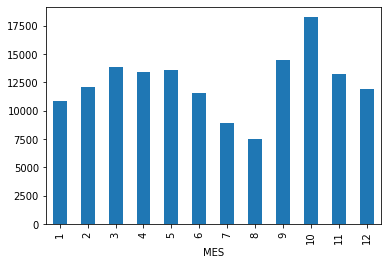

In [19]:
clm_encoded.groupby('MES')['VIAJES_OFERTADOS'].sum().plot(kind='bar')
plt.show()

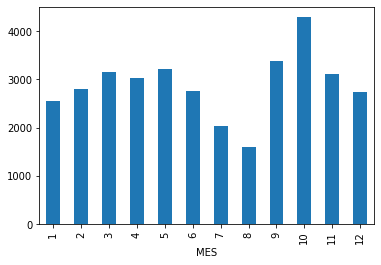

In [20]:
clm_encoded.groupby('MES')['VIAJES_CONFIRMADOS'].sum().plot(kind='bar')
plt.show()

Los datos no se encuentran desbalanceados, por lo que no será necesario utilizar técnicas de balanceo.

## Andalucia

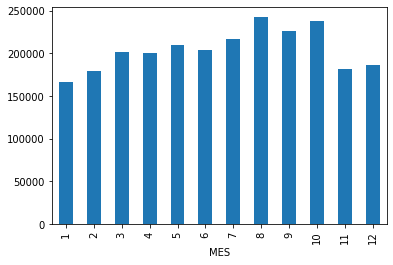

In [21]:
andalucia_encoded.groupby('MES')['VIAJES_OFERTADOS'].sum().plot(kind='bar')
plt.show()

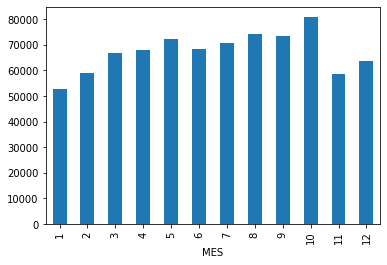

In [22]:
andalucia_encoded.groupby('MES')['VIAJES_CONFIRMADOS'].sum().plot(kind='bar')
plt.show()

Los datos no se encuentran desbalanceados, por lo que no será necesario utilizar técnicas de balanceo.

## Visualizacion de variable a inferir y correlación

A continuación se muestran unas matrices de correlación para tener una impresión a simple vista de la influencia de unas características sobre otras.

In [23]:
def graph_correlation(corr_matrix):
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 13))

  sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
  )

  ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
  )

  ax.tick_params(labelsize = 10)


### Castilla-la Mancha

In [24]:
def correlation_pearson(df):
  corr_matrix = df.corr(method='pearson')
  return corr_matrix

In [25]:
clm_features_selectec = clm_encoded.copy()
clm_features_selectec.tail(2)

,DIA,AÑO,SEMANA,MES,ASIENTOS_OFERTADOS,ASIENTOS_CONFIRMADOS,VIAJES_OFERTADOS,VIAJES_CONFIRMADOS,OFERTANTES,OFERTANTES_NUEVOS,ORIGEN,DESTINO,INTERPROVINCIAL,FESTIVO
20860,2018-07-14,2018,28,7,3.0,1,1,1,1,0,52,139,1,0
20861,2018-08-10,2018,32,8,5.0,1,2,1,1,0,52,44,1,0


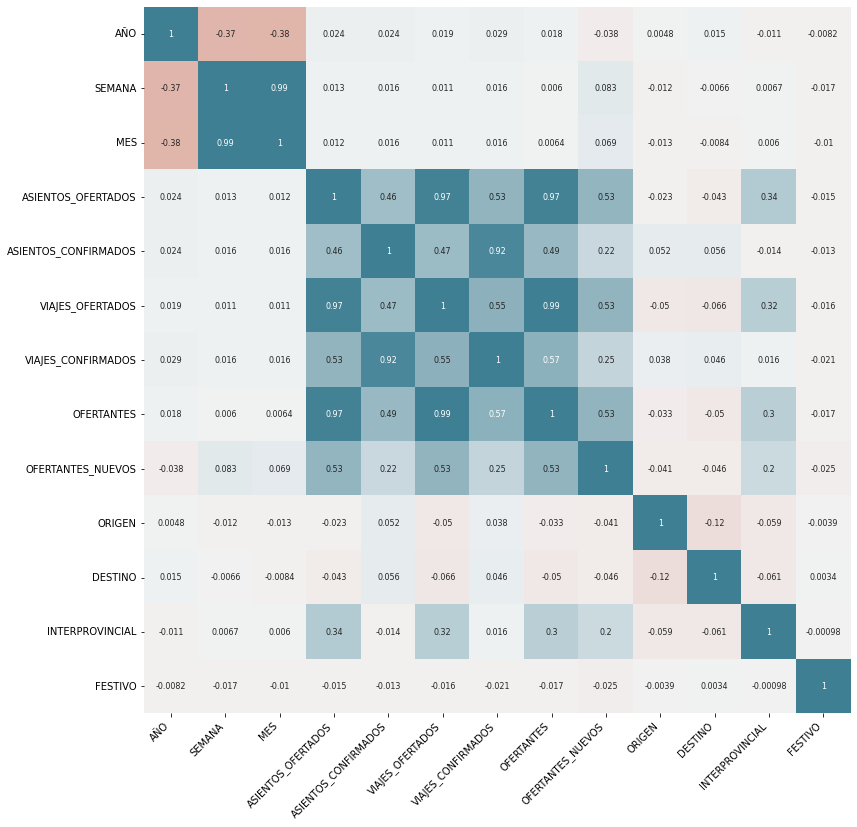

In [26]:
clm_corr = correlation_pearson(clm_features_selectec)
graph_correlation(clm_corr)

### Andalucia

In [27]:
andalucia_features_selectec = andalucia_encoded.copy()
andalucia_features_selectec.tail(2)

,DIA,AÑO,SEMANA,MES,ASIENTOS_OFERTADOS,ASIENTOS_CONFIRMADOS,VIAJES_OFERTADOS,VIAJES_CONFIRMADOS,OFERTANTES,OFERTANTES_NUEVOS,ORIGEN,DESTINO,INTERPROVINCIAL,FESTIVO
246053,2018-06-08,2018,23,6,3.0,2,1,1,1,1,296,142,0,0
246054,2018-07-06,2018,27,7,4.0,1,1,1,1,0,428,25,1,0


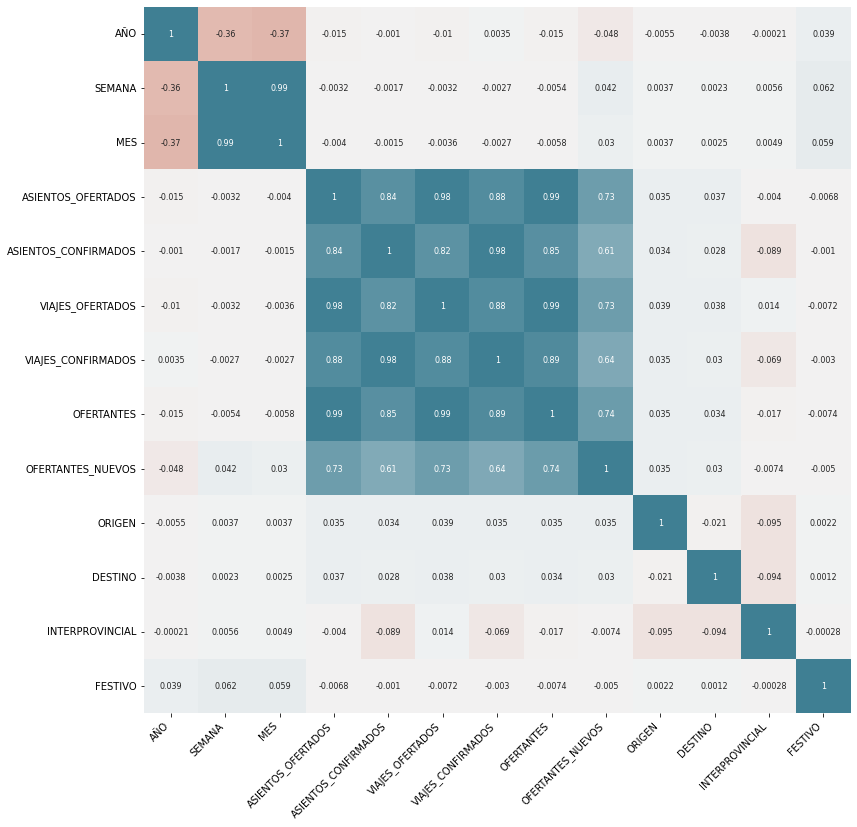

In [28]:
andalucia_corr = correlation_pearson(andalucia_features_selectec)
graph_correlation(andalucia_corr)

Como era de esperar las características creadas por nosotros tienen un impacto mucho menor en **VIAJES_CONFIRMADOS** (columna a inferir) que las variables que se encuentran en el dataset de inicio.

Por otro lado nos impresiona la gran correlación existente entre la característica interprovincial de Castilla-la Mancha y la de viajes confirmados. Esto puede ser debido a el tamaño de la comunidad o a que sus habitantes necesiten más medios de transporte. Lo único que conocemos con certeza es que no supone ningún problema para blablacar ya que puede seguir ofertando plazas interprovinciales, a priori, con gran interés por los usuarios.

# Modelo de viajes

## Random Forest con CV

Se realizó un modelo base con múltiples cambios pequeños para conseguir pequeñas mejoras en cada modelo. Se decidieron incluir en el modelo las caracteristicas de año, semana, mes, asientos ofertados, viajes ofertados, destino, origen, interprovincial, festivo, asientos ofertados y asientos confirmados, razón de esta última:

Ya que conocemos todos los datos de cada ruta diaria, para saber si esta ruta se va a realizar o no, parece necesario saber cuantas plazas se encuentran reservadas por el momento.

In [29]:
def modelo(df, inferir, iterations):
  df =  df.set_index('DIA')
  X = df.drop(labels=['VIAJES_CONFIRMADOS','OFERTANTES_NUEVOS'], axis = 1)
  y=df[[inferir]]

  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42)
  print("X_train df\n", X_train.head(3))
  cv = TimeSeriesSplit(n_splits = 3)
  total_scores = []
  for i in range(1,iterations):
        fold_mae = []
        regr = tree.DecisionTreeRegressor(max_depth=i)
        for train_fold, test_fold in cv.split(X_train):
            fx_train = X_train.iloc[train_fold]
            fy_train = y_train.iloc[train_fold]

            fx_test = X_train.iloc[test_fold]
            fy_test = y_train.iloc[test_fold]

            regr.fit(fx_train, fy_train.values.ravel())
            y_pred = regr.predict(fx_test)
            mae = metrics.mean_absolute_error(fy_test, y_pred)
            fold_mae.append(mae)
        total_scores.append(sum(fold_mae)/len(fold_mae))
        
  depth = np.argmin(total_scores) + 1
  plt.plot(range(1,len(total_scores)+1), total_scores, 
            marker='o')
  print ('\nMin Value : ' +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
  plt.ylabel('MAE')
  plt.show()

  regressor = RandomForestRegressor(max_depth = depth, criterion='absolute_error', random_state=2)
  regressor.fit(X_train, y_train.values.ravel())

  y_pred = regressor.predict(X_test) 
  
  print ("MAE:", metrics.mean_absolute_error(y_pred , y_test))
  print ("MAPE:", metrics.mean_absolute_percentage_error(y_pred , y_test))
  print ("MSE:", metrics.mean_squared_error(y_pred , y_test))
  print ("R^2:", metrics.r2_score(y_pred , y_test))

  xx = np.stack(i for i in range(len(y_test)))
  plt.scatter(xx, y_test, c='r', label='data')
  plt.plot(xx, y_pred, c='g', label='prediction')
  plt.axis('tight')
  plt.title("RandomForests Regressor")

  plt.show()

  print ('Feature Relevancies')
  print(pd.DataFrame({'Attributes': X_train.columns ,
              'Decision Tree': regressor.feature_importances_}))

  return regressor

### Castilla-la Mancha

X_train df
              AÑO  SEMANA  MES  ...  DESTINO  INTERPROVINCIAL  FESTIVO
DIA                            ...                                   
2019-02-01  2019       5    2  ...        7                1        0
2018-05-04  2018      18    5  ...        1                1        1
2018-08-04  2018      31    8  ...       42                1        0

[3 rows x 11 columns]

Min Value : 0.2480258603429576 (6)


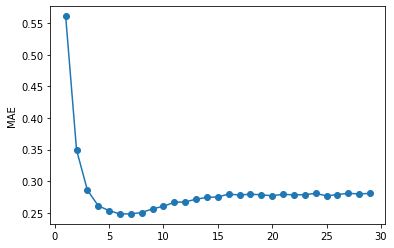

MAE: 0.22493928742610642
MAPE: 0.115896819591292
MSE: 0.21382761223837674
R^2: 0.8427781340342695


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


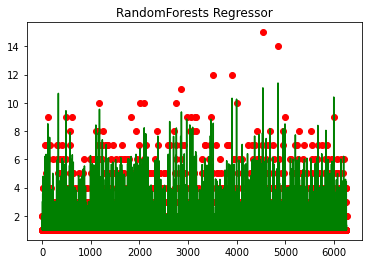

Feature Relevancies
              Attributes  Decision Tree
0                    AÑO       0.000397
1                 SEMANA       0.001430
2                    MES       0.000340
3     ASIENTOS_OFERTADOS       0.004854
4   ASIENTOS_CONFIRMADOS       0.907464
5       VIAJES_OFERTADOS       0.041503
6             OFERTANTES       0.041155
7                 ORIGEN       0.001156
8                DESTINO       0.001308
9        INTERPROVINCIAL       0.000251
10               FESTIVO       0.000141


In [30]:
regressor_clm = modelo(clm_encoded, 'VIAJES_CONFIRMADOS',20)

Como resultado obtenemos unas métricas del modelo bajas, hay poco ruido en los datos y el modelo parece ser bastante bueno.

### Andalucía

In [36]:
# regressor_andalucia = modelo(andalucia_encoded, 'VIAJES_CONFIRMADOS',15)

# Predicciones

A continuación mostramos una interfaz bastante simple para realizar las predicciones.

In [32]:
def interprovincial(municipioA, municipioB):
  filaA = ccaa[ccaa['Municipio'] == municipioA]
  filaB = ccaa[ccaa['Municipio'] == municipioB]
  provinciaA = filaA.iloc[0]['Provincia']
  provinciaB = filaB.iloc[0]['Provincia']
  if provinciaA == provinciaB:
    return 1
  else:
    return 0

## Predicción para la empresa en Castilla-la Mancha

In [33]:
orig = clm.ORIGEN.astype('category')
origen_dic = dict(enumerate(orig.cat.categories))

desti = clm.DESTINO.astype('category')
destino_dic = dict(enumerate(desti.cat.categories))

interprovincial_clm = clm.INTERPROVINCIAL.astype('category')
interprovincial_dic_clm =dict(enumerate(interprovincial_clm.cat.categories))

In [34]:
regressor_clm.feature_names_in_

array(['AÑO', 'SEMANA', 'MES', 'ASIENTOS_OFERTADOS',
       'ASIENTOS_CONFIRMADOS', 'VIAJES_OFERTADOS', 'OFERTANTES', 'ORIGEN',
       'DESTINO', 'INTERPROVINCIAL', 'FESTIVO'], dtype=object)

In [49]:
#@title Origen

origen_clm_word = 'Albacete' #@param {type:"string"}

origen_clm = list(origen_dic.keys())[list(origen_dic.values()).index(origen_clm_word)]
origen_clm

1

In [50]:
#@title Destino

destino_clm_word = 'Guadalajara' #@param {type:"string"}
destino_clm = list(destino_dic.keys())[list(destino_dic.values()).index(destino_clm_word)]
destino_clm

62

In [38]:
interprovincial_clm = interprovincial(origen_clm_word, destino_clm_word)

In [51]:
from datetime import datetime

#@title Fecha de viajes
dia_clm = '2018-02-13' #@param {type:"date"}


date_clm = pd.Timestamp(dia_clm)
mes_clm = date_clm.month

semana_clm = date_clm.week
año_clm = date_clm.year
print(mes_clm,año_clm,semana_clm)

2 2018 7


In [52]:
#@title Número de asientos ofertados y confirmados hasta la fecha

asientos_ofertados_clm = 11 #@param {type:"slider", min:1, max:80, step:1}

asientos_confirmados_clm = 4 #@param {type:"slider", min:1, max:80, step:1}

if asientos_confirmados_clm > asientos_ofertados_clm:
  asiento_confirmado_clm = 0
  print('Asientos confimados no válidos, se asumirá que ningún asiento fue confirmado')

In [53]:
#@title Viajes ofertados

viajes_ofertados_clm = 4 #@param {type:"slider", min:1, max:30, step:1}

In [54]:
#@title Número de rutas disponibles para este viaje

ofertantes_clm = 4 #@param {type:"slider", min:1, max:70, step:1}

In [55]:
#@title Festivo

festivo_clm = False #@param ["False", "True"] {type:"raw"}
festivo_clm = 0 if festivo_clm == False else 1

In [56]:
dic_caracteristicas_clm = {'DIA':date_clm, 'AÑO':año_clm, 'SEMANA':semana_clm, 'MES':mes_clm, 'ASIENTOS_OFERTADOS': asientos_ofertados_clm,
       'ASIENTOS_CONFIRMADOS':asientos_confirmados_clm, 'VIAJES_OFERTADOS':viajes_ofertados_clm, 'OFERTANTES':ofertantes_clm, 'ORIGEN':origen_clm,
       'DESTINO':destino_clm, 'INTERPROVINCIAL':interprovincial_clm, 'FESTIVO':festivo_clm}
df_viaje_clm = pd.DataFrame(dic_caracteristicas_clm, index=[0])
df_viaje_clm = df_viaje_clm.set_index('DIA')
df_viaje_clm

,AÑO,SEMANA,MES,ASIENTOS_OFERTADOS,ASIENTOS_CONFIRMADOS,VIAJES_OFERTADOS,OFERTANTES,ORIGEN,DESTINO,INTERPROVINCIAL,FESTIVO
DIA,,,,,,,,,,,
2018-02-13,2018,7,2,11,4,4,4,1,62,1,0


In [57]:
pred_clm =  regressor_clm.predict(df_viaje_clm)[0]
print("Viajes que se van a confirmar: ", pred_clm)
porcentaje = (round((pred_clm/viajes_ofertados_clm)*100))
print("Corresponde a un {porcentaje}%, ¿se debe dar publicidad a estas rutas? {respuesta}".format(porcentaje = porcentaje, respuesta = 'No' if porcentaje>65 else 'Si'))

Viajes que se van a confirmar:  2.05
Corresponde a un 51%, ¿se debe dar publicidad a estas rutas? Si


### Predicción VS Valores reales

In [59]:
to_predict = {'DIA':'2018-02-13', 'AÑO':2018, 'SEMANA':7, 'MES':2, 'ASIENTOS_OFERTADOS': 11,
          'ASIENTOS_CONFIRMADOS':4, 'VIAJES_OFERTADOS':4, 'OFERTANTES':4, 'ORIGEN':1,
          'DESTINO':62, 'INTERPROVINCIAL':0, 'FESTIVO':0}

pred_clm =  regressor_clm.predict(df_viaje_clm)[0]
data_value = clm[clm['DIA'] == '2018-02-13'] #and clm[clm['AÑO'] == 2018]# and clm['VIAJES_OFERTADOS'] == 4]
data_value = data_value[data_value['ORIGEN']=='Albacete']
data_value = data_value[data_value['DESTINO']=='Guadalajara']
data_value = data_value[data_value['ASIENTOS_OFERTADOS']==11]
print("Viajes reales realizados {}, viajes predichos {}".format(data_value['VIAJES_CONFIRMADOS'].tolist()[0],pred_clm))

Viajes reales realizados 3, viajes predichos 2.05


## Predicción para la empresa en Andalucia

In [46]:
'''
orig = andalucia.ORIGEN.astype('category')
origen_dic = dict(enumerate(orig.cat.categories))

desti = andalucia.DESTINO.astype('category')
destino_dic = dict(enumerate(desti.cat.categories))

interprovincial_andalucia = andalucia.INTERPROVINCIAL.astype('category')
interprovincial_dic_andalucia =dict(enumerate(interprovincial_andalucia.cat.categories))

#@title ORIGEN

origen_andalucia_word = 'Lepe' #@param {type:"string"}

origen_andalucia = list(origen_dic.keys())[list(origen_dic.values()).index(origen_andalucia_word)]

#@title DESTINO

destino_andalucia_word = 'Cordoba' #@param {type:"string"}
destino_andalucia = list(destino_dic.keys())[list(destino_dic.values()).index(destino_andalucia_word)]

interprovincial_andalucia = interprovincial(origen_andalucia_word, destino_andalucia_word)

from datetime import datetime

#@title FECHA DE VIAJES
dia_andalucia = '2022-01-24' #@param {type:"date"}


date_andalucia = pd.Timestamp(dia_andalucia)
mes_andalucia = date_andalucia.month

semana_andalucia = date_andalucia.week
año_andalucia = date_andalucia.year
print(mes_andalucia,año_andalucia,semana_andalucia)

#@title Número de asientos ofertados y confirmados hasta la fecha

asientos_ofertados_andalucia = 38 #@param {type:"slider", min:1, max:80, step:1}

asientos_confirmados_andalucia = 23 #@param {type:"slider", min:1, max:80, step:1}

if asientos_confirmados_andalucia > asientos_ofertados_andalucia:
  asiento_confirmado_andalucia = 0
  print('Asientos confimados no válidos, se asumirá que ningún asiento fue confirmado')

#@title Viajes ofertados

viajes_ofertados_andalucia = 16 #@param {type:"slider", min:1, max:30, step:1}

#@title Número de rutas disponibles para este viaje

ofertantes_andalucia = 21 #@param {type:"slider", min:1, max:70, step:1}

#@title Festivo

festivo_andalucia = True #@param ["False", "True"] {type:"raw"}
festivo_andalucia = 0 if festivo_andalucia == False else 1

dic_caracteristicas_andalucia = {'DIA':date_andalucia, 'AÑO':año_andalucia, 'SEMANA':semana_andalucia, 'MES':mes_andalucia, 'ASIENTOS_OFERTADOS': asientos_ofertados_andalucia,
       'ASIENTOS_CONFIRMADOS':asientos_confirmados_andalucia, 'VIAJES_OFERTADOS':viajes_ofertados_andalucia, 'OFERTANTES':ofertantes_andalucia, 'ORIGEN':origen_andalucia,
       'DESTINO':destino_andalucia, 'INTERPROVINCIAL':interprovincial_andalucia, 'FESTIVO':festivo_andalucia}
df_viaje_andalucia = pd.DataFrame(dic_caracteristicas_andalucia, index=[0])
df_viaje_andalucia = df_viaje_andalucia.set_index('DIA')

pred_andalucia =  regressor_andalucia.predict(df_viaje_andalucia)[0]
print("Viajes que se van a confirmar: ", pred_andalucia)
porcentaje = (round((pred_andalucia/viajes_ofertados_andalucia)*100))
print("Corresponde a un {porcentaje}%, ¿se debe dar publicidad a estas rutas? {respuesta}".format(porcentaje = porcentaje, respuesta = 'No' if porcentaje>65 else 'Si'))

'''

'\norig = andalucia.ORIGEN.astype(\'category\')\norigen_dic = dict(enumerate(orig.cat.categories))\n\ndesti = andalucia.DESTINO.astype(\'category\')\ndestino_dic = dict(enumerate(desti.cat.categories))\n\ninterprovincial_andalucia = andalucia.INTERPROVINCIAL.astype(\'category\')\ninterprovincial_dic_andalucia =dict(enumerate(interprovincial_andalucia.cat.categories))\n\n#@title ORIGEN\n\norigen_andalucia_word = \'Lepe\' #@param {type:"string"}\n\norigen_andalucia = list(origen_dic.keys())[list(origen_dic.values()).index(origen_andalucia_word)]\n\n#@title DESTINO\n\ndestino_andalucia_word = \'Cordoba\' #@param {type:"string"}\ndestino_andalucia = list(destino_dic.keys())[list(destino_dic.values()).index(destino_andalucia_word)]\n\ninterprovincial_andalucia = interprovincial(origen_andalucia_word, destino_andalucia_word)\n\nfrom datetime import datetime\n\n#@title FECHA DE VIAJES\ndia_andalucia = \'2022-01-24\' #@param {type:"date"}\n\n\ndate_andalucia = pd.Timestamp(dia_andalucia)\nmes_

# Guardar modelos

In [ ]:
import joblib

joblib.dump(regressor_clm, "regressor_clm.joblib")

In [ ]:
#joblib.dump(regressor_andalucia, "regressor_andalucia.joblib")